In [94]:
import sys, site
sys.path.append(site.getusersitepackages())

import nilearn
print(nilearn.__version__)


0.13.0


In [95]:
import sys
!{sys.executable} -m pip install --user brainspace


In [96]:
import sys, site
sys.path.append(site.getusersitepackages())

import brainspace
print(brainspace.__version__)


0.1.22


In [97]:
import sys
!{sys.executable} -m pip install --user neuromaps


In [98]:
import sys, site
sys.path.append(site.getusersitepackages())

import neuromaps
print(neuromaps.__version__)


0.0.5


In [99]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import seaborn as sns
from scipy.spatial.distance import cdist
from brainspace.null_models.variogram import SurrogateMaps
from matplotlib.colors import ListedColormap

In [100]:
main_path = "/home/m-ehara/project/diffparc-smk"

In [101]:
data_path = main_path + "/PNI/"
results_path = main_path + "/results/diffparc/tpl-MNI152NLin6Asym/"
#fig_path = main_path + "/results/diffparc/figures/"

In [102]:
data = load(results_path + 'tpl-MNI152NLin6Asym_label-fullBF_desc-Linear_schaefer400_from-group_conn_voxelwise_400targets.npz') #change the npz file name as necessary
correlation = data['conn_group']

In [103]:
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

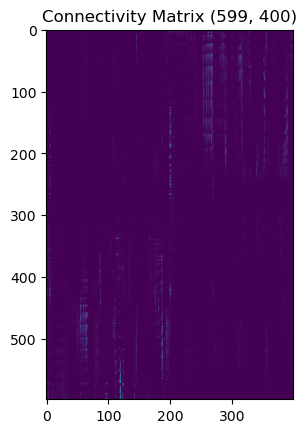

In [104]:
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_avg)
ax.set_title('Connectivity Matrix {}'.format(corr_avg.shape))
plt.show()

In [105]:
s= corr_avg.sum(axis=0)
sr=np.round(s).astype(int)
sdf=pd.DataFrame(sr)
sdf.T

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,89053,131912,3348,71572,25881,1698,197596,2340,16530,13793,...,136224,27623,11851,9354,20412,6810,24380,55223,7275,19150


In [106]:
stdf=sdf.T

In [107]:
stdf.style

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,89053,131912,3348,71572,25881,1698,197596,2340,16530,13793,12046,8285,17320,1787,20696,8204,2178,23738,4070,14425,20142,22001,3261,16115,23444,18401,3585,4910,38772,33841,12242,6731,2516,29687,7885,15286,1805,9388,2235,10506,1773,2138,11831,4477,2009,2376,16210,2815,19825,7910,14593,32623,12290,21999,15256,32513,129885,20067,33746,37186,91806,70062,38563,65484,97344,111610,46591,43785,5823,10205,3117,2205,10804,3036,6654,757,7183,9984,11340,7360,46977,16214,41793,35369,22203,8385,28725,7147,89477,11635,5189,4813,6208,3651,8035,2442,8277,34535,5160,19732,5980,3183,6956,6105,17606,12038,13772,23525,20565,40872,50645,11154,91084,24477,27814,18860,27368,28170,22029,70582,187733,1631,14445,22191,55683,58570,9454,2842,2480,16044,2655,1428,2179,14223,25119,7996,12073,6601,7974,7748,2712,3907,6303,40847,15721,15631,90508,51260,2074,1231,1486,2342,4152,1307,1530,2373,1343,1267,1645,1192,10037,4756,2407,10783,6011,12024,9840,13248,18145,15832,8680,24466,10130,14678,16112,22696,18918,64033,37358,23063,18186,9496,70812,24102,8672,14429,23002,157237,196090,17861,16581,15368,10369,23755,21965,85005,43274,38348,18289,56753,172289,207154,82051,1089,38842,8938,58790,6050,2820,676,5467,11691,6931,14830,13210,1108,11311,6440,9663,6715,8507,3050,16325,9330,12367,4650,6831,22635,24254,6648,10732,3932,9513,12018,19223,31334,4420,2546,9107,33610,8513,33892,10465,8057,9140,14060,1638,3626,1058,5880,3033,11482,3984,21904,17555,153938,22383,37183,37118,40214,170677,25845,91200,91606,65519,85522,47853,149723,208153,76571,95953,3648,6092,5074,30575,918,13968,7934,1705,6612,15658,24555,49050,4595,31948,9229,67845,29624,53174,41527,69890,84269,28097,6269,1067,1324,5990,4665,1828,2093,14926,21956,4637,15150,10693,9188,12023,16915,23998,14491,18296,21007,78595,26008,63784,45165,95104,108975,15458,26837,15025,18095,8179,25835,25436,2934,2137,12160,25914,2712,82921,1842,1215,14430,1143,3108,3205,4374,8272,10522,23177,41989,20701,25877,17009,9265,9577,22710,11333,3862,13199,20623,38209,81275,99636,22808,19133,84246,12858,10279,28984,3530,3109,3952,1407,5381,15608,1025,10391,19386,2142,2577,3789,3182,16197,15936,22973,23538,14672,32102,4343,16969,28544,7603,32082,35575,29626,34580,92388,53111,136224,27623,11851,9354,20412,6810,24380,55223,7275,19150


In [108]:
n_components=100 # specify gradinet components here

In [109]:
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=n_components, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avg))

GradientMaps(n_components=100, random_state=0)


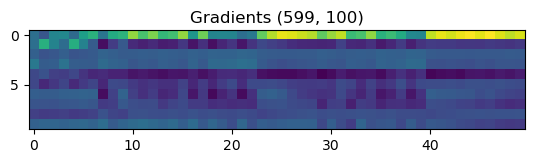

In [110]:
# Plot this gradients (up to 10 component and 50 BF voxel)
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50,:10].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

In [111]:
pd.DataFrame(gm.gradients_).to_csv(results_path + f'Diff_gradients-{n_components}_seed-BASF_1p6mm.csv', index=False)

In [112]:
# save the BF gradients (up to 6 components) as nifti files
seed_file = (main_path + '/resources/seed_1p6mm.nii.gz')
seed = nib.load(seed_file)
seed_vol = seed.get_fdata()
mask = data['mask']
affine = data['affine']

for gradi in range(n_components):

    grad_vol = np.zeros(mask.shape)
    grad_vol[mask > 0] = gm.gradients_[:,gradi]
    
    grad_nib = nib.Nifti1Image(grad_vol,affine,header=seed.header)
    grad_nib.to_filename(results_path + f'Diff_gradient_{gradi+1}.nii.gz')

/tmp/ipykernel_1174212/620268081.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


NameError: name 'fig_path' is not defined

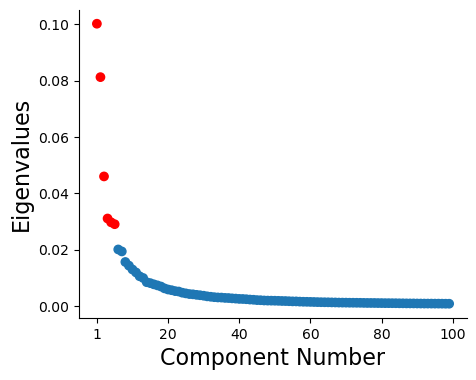

In [113]:
fig, ax = plt.subplots(1, figsize=(5, 4))
x = np.arange(n_components)
y = gm.lambdas_
color = np.where(x < 6, "red", "C0")
ax.scatter(x, y, c = color)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Eigenvalues', fontsize=16)
plt.savefig(fig_path + f'Diff_Gradient_eiganvalue_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

fname = (results_path + 'Diff_gradient_{0}.nii.gz')

In [114]:
G_idx = {}
G_values = {}
for g in range(1,7):
    G_nii = nib.load(fname.format(g)).get_fdata()
    G_idx[g] = np.argwhere(G_nii)
    G_values[g] = G_nii[G_idx[g][:,0], G_idx[g][:,1], G_idx[g][:,2]].flatten()

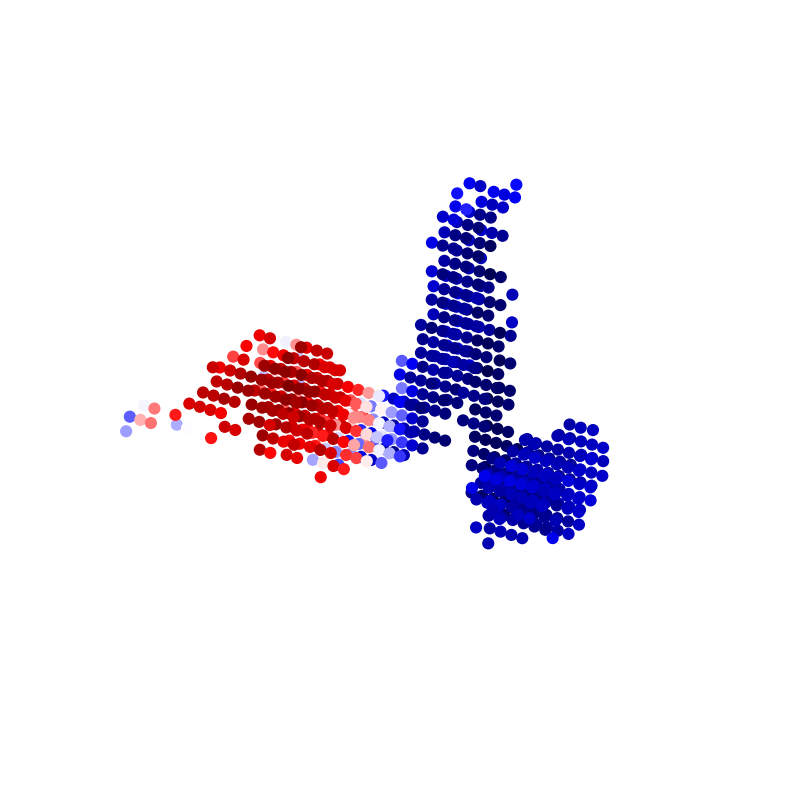

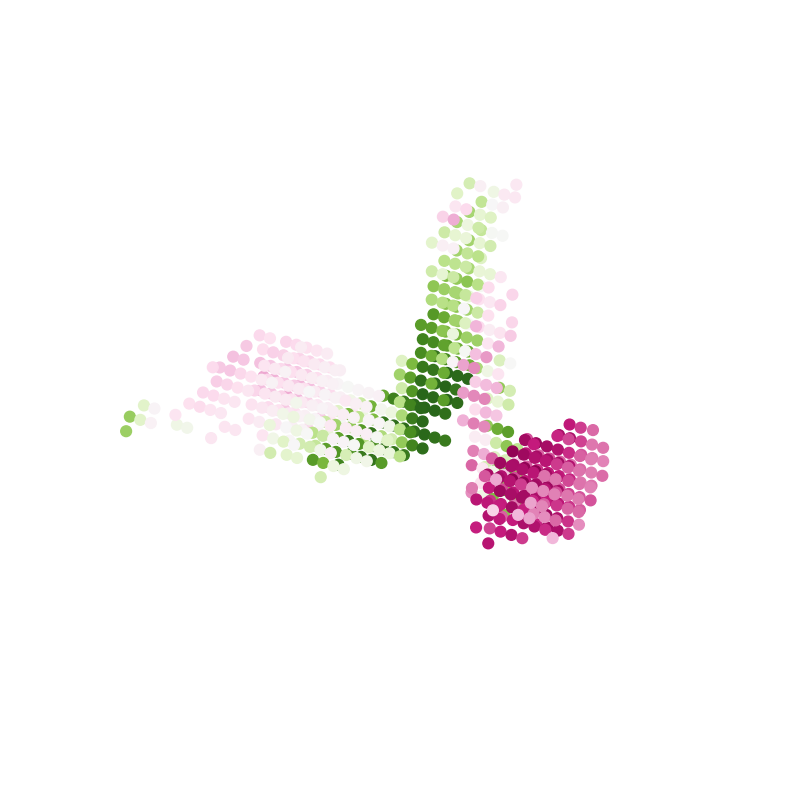

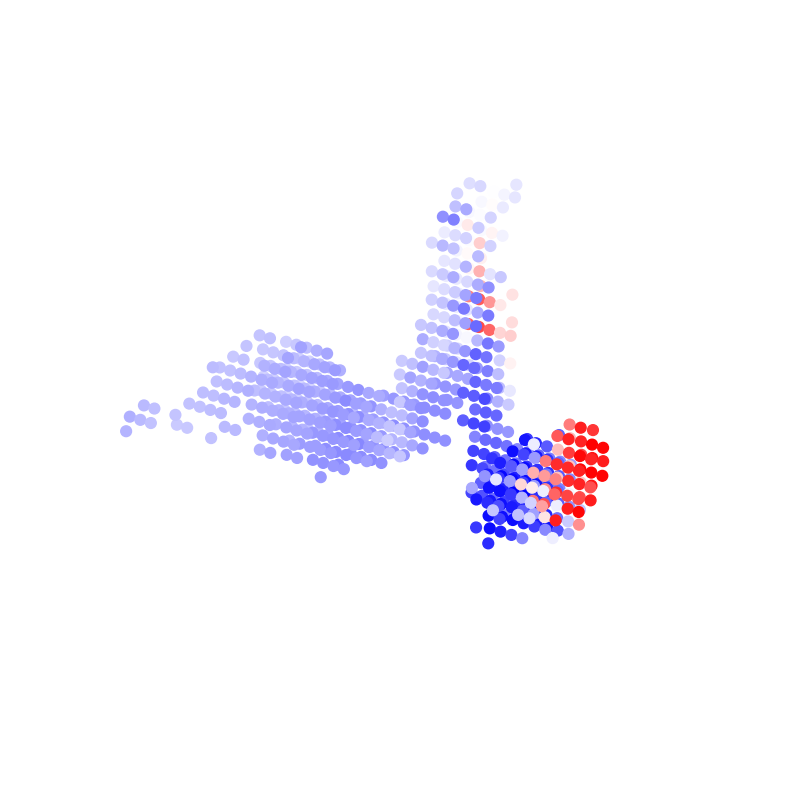

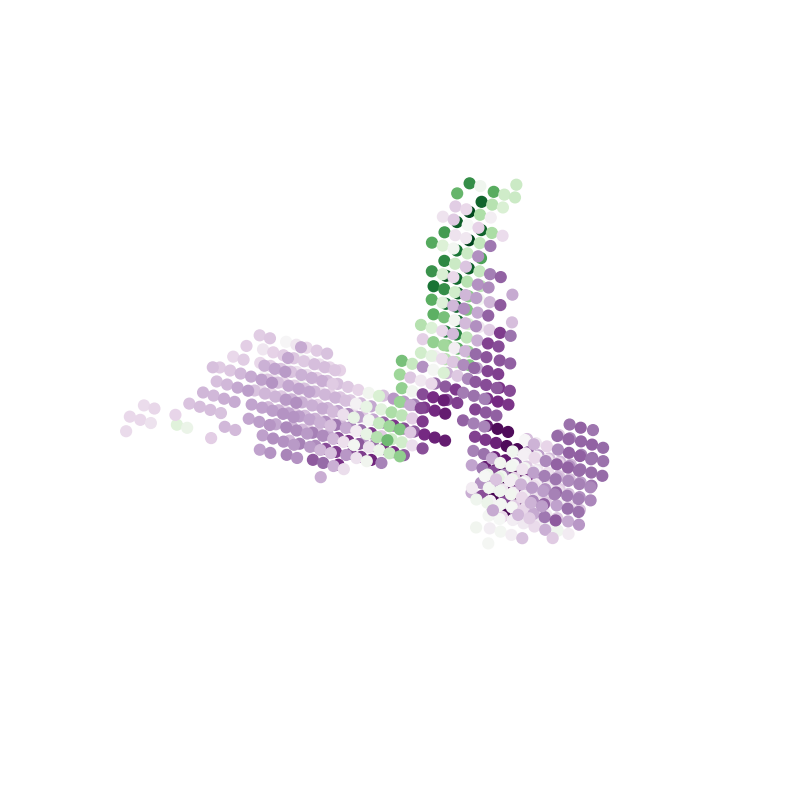

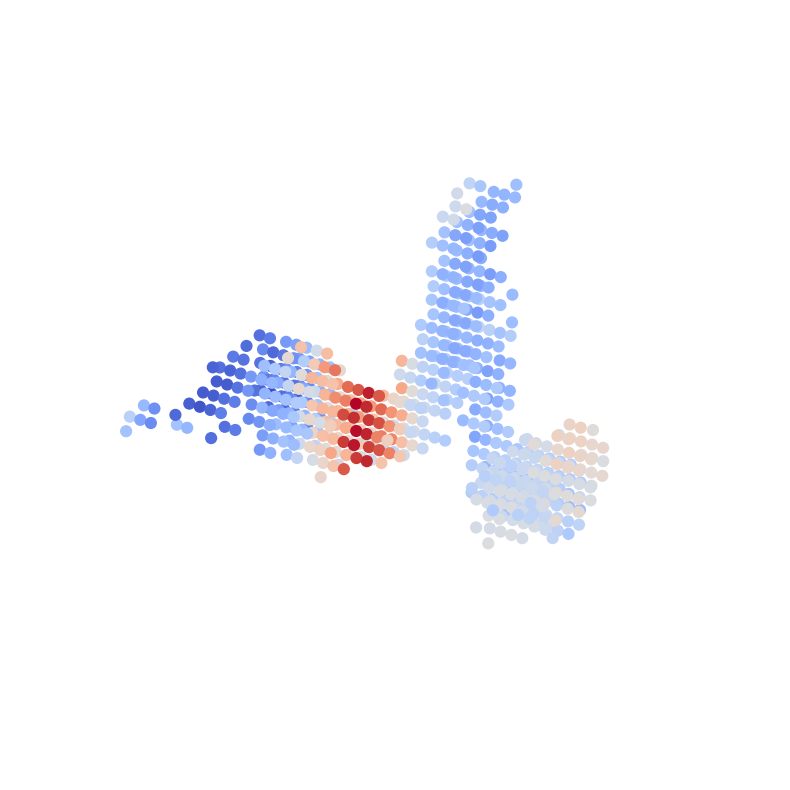

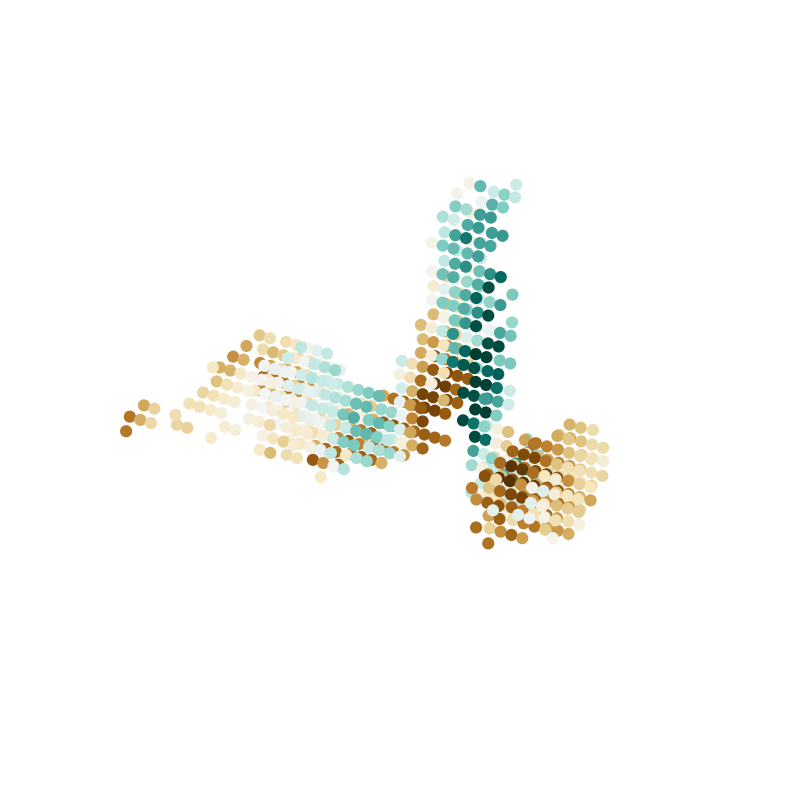

In [115]:

colors = ['seismic','seismic','PiYG','bwr','PRGn','coolwarm','BrBG']

for g in range(1,7):
    # Plot using 3D scatter plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.dist=10
    ax.set_axis_off()
    
    ax.scatter(
        G_idx[g][:,0],
        G_idx[g][:,1],
        G_idx[g][:,2],
        s=60, alpha=1,
        cmap=colors[g], vmin=G_values[g].min(), vmax=G_values[g].max(), 
        c=G_values[g]
    )
    # Add legend    
    #norm = matplotlib.colors.Normalize(G_values[g].min(), G_values[g].max())
    #cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
    #cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=colors[g]), 
    #                  ticks=[G_values[g].min(), G_values[g].max()], cax=cb_ax, orientation='horizontal')
    #cb.set_label(f"Gradient {g}", fontsize=18, labelpad=-10, weight=600)
    #cb.ax.set_xticklabels(['−','+'], fontsize=20, weight=600) 
    
    #plt.savefig(fig_path + f'Diff_Gradient_{g}_scatterplot.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()